In [0]:
 # mount google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
from fastai.vision import *
from fastai.widgets import *
from fastai.callbacks import *
from fastai.text import *
import os
import pickle

###Import csv with image paths

In [0]:
#path to csv with name of images
filename = '/content/drive/My Drive/train_images_c4_pp.csv'

In [0]:
#load dataset with image paths
df = pd.read_csv(filename, usecols = ['name', 'label'])
df.head()

,filename,AdoptionSpeed
0,4374d6f52-1.jpg,3
1,3cf06742b-1.jpg,3
2,4a56df934-1.jpg,3
3,165e76ebb-1.jpg,3
4,8368a0a44-1.jpg,3


### Model set-up

In [0]:
# https://docs.fast.ai/vision.transform.html#get_transforms
# transformations of images to reduce overfitting

tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=10.,
                      max_zoom=1.1, max_lighting=0.2, max_warp=0.2, 
                      p_affine=1.0, p_lighting=0.0)

In [0]:
# to ensure reproducibility
#  https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/15
# num_workers=0 for it to be reproducible.

def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [0]:
random_seed(42, use_cuda=True)

###Pre-process images

In [0]:
#path to where the images are stored
path = "/content/drive/My Drive/train_images/"

In [0]:
#load databunch in case available
data = load_data("/content/drive/My Drive/models/databunch/", "image_databunch.pkl")

In [0]:
#pre-processes images by resizing and using image paths specified in df
#applying transformations
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=256, bs=8, seed=42, num_workers=0)

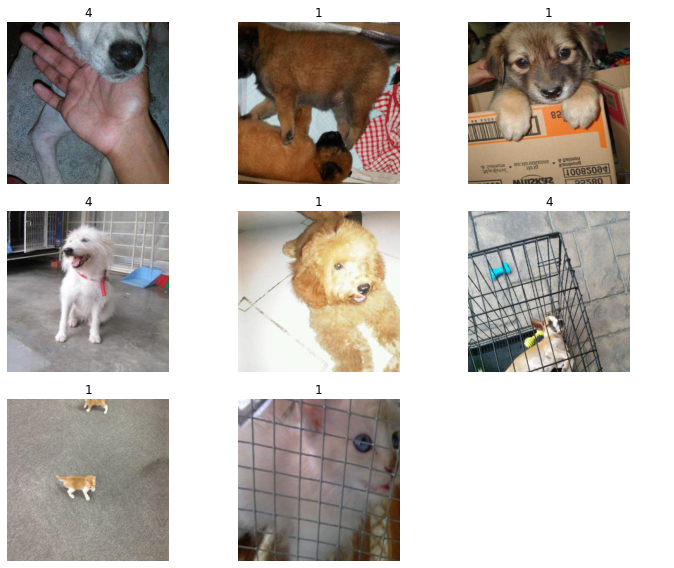

In [0]:
#show a selection of pre-processed images
data.show_batch(rows=3, figsize=(10,8))

In [0]:
#save imagedatabunch 
data.save("/content/drive/My Drive/models/databunch/co_image_c4_q-1_s256.pkl")

### Model training

In [0]:
#implement weighted cohen's kappa metric
kappa = KappaScore()
kappa.weights = "quadratic"

In [0]:
#densenet121 model
learn = cnn_learner(data, models.densenet121, metrics=[accuracy, kappa],
                    callback_fns=[partial(CSVLogger, append=True)])

In [0]:
#resnet34 model
#learn = cnn_learner(data, models.resnet34, metrics=[accuracy, kappa],
#                    callback_fns=[partial(CSVLogger, append=True)]) 

In [0]:
#vgg19 model
#learn = cnn_learner(data, models.vgg19_bn, metrics=[accuracy, kappa],
#                   callback_fns=[partial(CSVLogger, append=True)])

In [0]:
#load model weights of learner in case available
learn.load('/content/drive/My Drive/models/learner_model/co_rs34-c4-q-1-s256-e10')

In [0]:
#train model on 10 epochs
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,1.342527,1.278238,0.420643,0.354204,1:04:28
1,1.327390,1.277842,0.403008,0.331401,04:34
2,1.342178,1.306881,0.369295,0.320699,04:31
3,1.331571,1.318353,0.375519,0.297316,04:30
4,1.334880,1.321866,0.348029,0.297940,04:28
5,1.334946,1.305400,0.382780,0.316810,04:30
6,1.306774,1.347186,0.378112,0.308411,04:30
7,1.318497,1.306731,0.392635,0.320767,04:31
8,1.295319,1.302671,0.392635,0.310852,04:26
9,1.283594,1.296126,0.393672,0.325554,04:23


In [0]:
# find the optimal learning rate to train our language model on
learn.lr_find(start_lr = 1e-8, end_lr =1e-2)
learn.recorder.plot(suggestion=True)

In [0]:
#save model weights
learn.save('/content/drive/My Drive/models/learner_model/co_densenet121-c4-q-1-s256-e10')

In [0]:
#export model to make predictions
learn.export('/content/drive/My Drive/models/learner_model/resnet34_under.pkl')

###Confusion Matrix

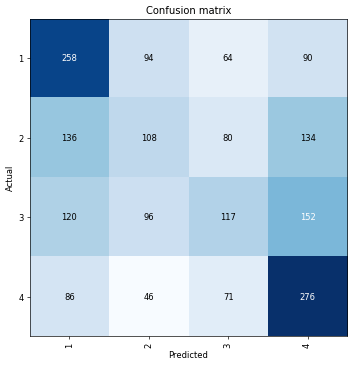

In [0]:
#create confusion matrix of model
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)